Reproduce the PRISM precipitation anomaly maps for each WT 
NPL_2022b
 

In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob 
import os.path
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

weather types are from <br>
/glade/campaign/mmm/c3we/mingge/ERA_INTERIM/WT  <br>
Produced by: AssignToExistingWTs_ERA_INTERIM.ipynb

In [2]:
level_s = np.array([0, 1, 2.5, 5, 7.5, 10, 15, 20,25, 37.5, 50,
         75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 750])

proj = ccrs.PlateCarree()

def ax_coastlines_country(ax_s):
    ax_s.coastlines(linewidths=0.5)
    ax_s.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))
 
def plot_prec_12(prec, min_v, max_v, n_lev, cmap_s, colorbar_ori, title_s):
    '''
    prec(12,nlat, nlon): 3d variable to plot
    colorbar_ori: colorbar orientation, verticle or horizontal
    title_s: the common title for subplot
    '''
    fig = plt.figure(figsize=(18,13))
    
    cnlevel = np.linspace(min_v, max_v, num=n_lev)
  
    for col in range(12):
        ax_s = plt.subplot(4, 3, col+1, projection=proj)
        ax_coastlines_country(ax_s)
        ax_s.add_feature(cfeature.STATES, linestyle=':')
        ax_s.add_feature(cartopy.feature.OCEAN,zorder=100, edgecolor='k')
 
        mem = col + 1

        im=prec[col].plot.contourf(
            levels=cnlevel,
            cmap=cmap_s,
            ax=ax_s,
            transform=proj,
            add_colorbar=False)
        
        plt.title('WT' + str(mem),fontweight="bold", size=15)

    # single title for All the Subplot
    fig.suptitle('member: ' + title_s, fontweight="bold", fontsize=30)
    
    fig.tight_layout()
    # The position of the bottom edge of the subplots, as a fraction of the figure height.
    #fig.subplots_adjust(bottom=0.15)

    #rect [left, bottom, width, height]
    #cbar_ax = fig.add_axes([0.2, 0.1, 0.7, 0.03])
    #fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
    if colorbar_ori=="vertical":
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.99, 0.1, 0.04, 0.8])
    else:
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.2, 0.001, 0.7, 0.03])
    
    fig.colorbar(im, cax=cbar_ax, orientation=colorbar_ori)
        

In [3]:
# centroid_ana.ibynb, wt_hist_smyle_era5.ipynb
sCentroids='/glade/u/home/mingge/WTing_existing-centroids/CONUS-WTs_existing_centroids.npz'
DATA=np.load(sCentroids)
rgrCentroids=DATA['rgrCentroids']               # (12, 3, 24, 74)
rgiWTs=range(1, rgrCentroids.shape[0]+1, 1)     # number of WT 

lat_s = DATA['rgrLatWT'].min() - 6
lat_e = DATA['rgrLatWT'].max() + 2
lon_s = DATA['rgrLonWT'].min()  
lon_e = DATA['rgrLonWT'].max() + 6
print('lat:', lat_s , '-', lat_e, 'lon:', lon_s, '-', lon_e)

lat: 24.75 - 50.0 lon: -125.25 - -64.5


In [4]:
dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/'
dir_wt = '/glade/campaign/mmm/c3we/mingge/ERA_INTERIM/WT/'

#### calculate prec climatology

In [5]:
year_s = 1981
year_e = 2014

flnm_nc = '/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_clim_1979-2014.nc'

if os.path.isfile(flnm_nc):
    print(flnm_nc, 'exist')
    with  xr.open_dataset(flnm_nc) as ds_prec:
        prec_mean = ds_prec.PR
        
else:  
    is_first = True
    for year in range(year_s, year_e+1, 1):
        flnm = dir_prism + 'PRISM_daily_ppt_' + str(year) + '.nc'
        print(flnm)
        with  xr.open_dataset(flnm) as ds:
            prec = ds.PR.sel(rlat=slice(lat_e, lat_s),rlon=slice(lon_s, lon_e)).mean(dim='time')
            #print(prec)
                
            if is_first == True:
                data_all = prec.copy()
                is_first = False
            else:
                data_all = xr.concat([data_all, prec], dim='time')
                           
    print(data_all.shape)
    prec_mean = data_all.mean(dim='time')
    prec_mean.to_netcdf( path = flnm_nc)    

/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_clim_1979-2014.nc exist


#### precipitation anomalies of WTs

In [9]:
n_wt  = 12

n_lat = prec_mean.shape[0]
n_lon = prec_mean.shape[1]

prec_3d = np.zeros((n_wt, n_lat, n_lon))

flnm_prec = '/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_wt.nc'
if os.path.isfile(flnm_prec):
    print(flnm_prec, 'exist')
    with  xr.open_dataset(flnm_prec) as ds:
        prec_xr = ds.__xarray_dataarray_variable__
else:
  for nw in range(n_wt):
    is_first = True
    for year in range(year_s, year_e+1, 1):
        StartDay = datetime.datetime(year,  1, 1,  0)
        EndDay   = datetime.datetime(year, 12, 31,  0)
        TimeDD   = pd.date_range(StartDay, EndDay, freq='d')
                 
        # read WT file
        flnm_wt = dir_wt + 'CONUS-WTs_' + str(year) +'.cla'
        print(flnm_wt)
            
        wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
        wts_g = wts.groupby(['wt']) 
        g_ind = wts_g.get_group(nw+1).index
            
        # read PRISM file
        flnm = dir_prism + 'PRISM_daily_ppt_' + str(year) + '.nc'
        print(flnm)
            
        with  xr.open_dataset(flnm) as ds:
            prec = ds.PR.sel(rlat=slice(lat_e, lat_s),rlon=slice(lon_s, lon_e))
            prec_wt = prec[g_ind,:,:]
            # check time coordinates associated with WT
            #print(prec_wt)
                
            if is_first == True:
                data_all = prec_wt.copy()
                is_first = False
            else:
                data_all = xr.concat([data_all, prec_wt.copy()], dim='time')
                #print(data_all.shape)
    print(data_all.shape)                
    prec_3d[nw] = data_all.mean("time") 
        
  prec_xr = xr.DataArray(prec_3d, 
                       coords={'lat':prec_mean.rlat, 'lon': prec_mean.rlon, 'wt':range(n_wt)},
                       dims=["wt", "rlat", "rlon"])
 
  prec_xr.to_netcdf(path = flnm_prec)             
  print(flnm_prec)

/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_wt.nc exist


#### ensemble average precipitation anomaly maps for each WT

https://www.frontiersin.org/articles/10.3389/fenvs.2019.00036/full

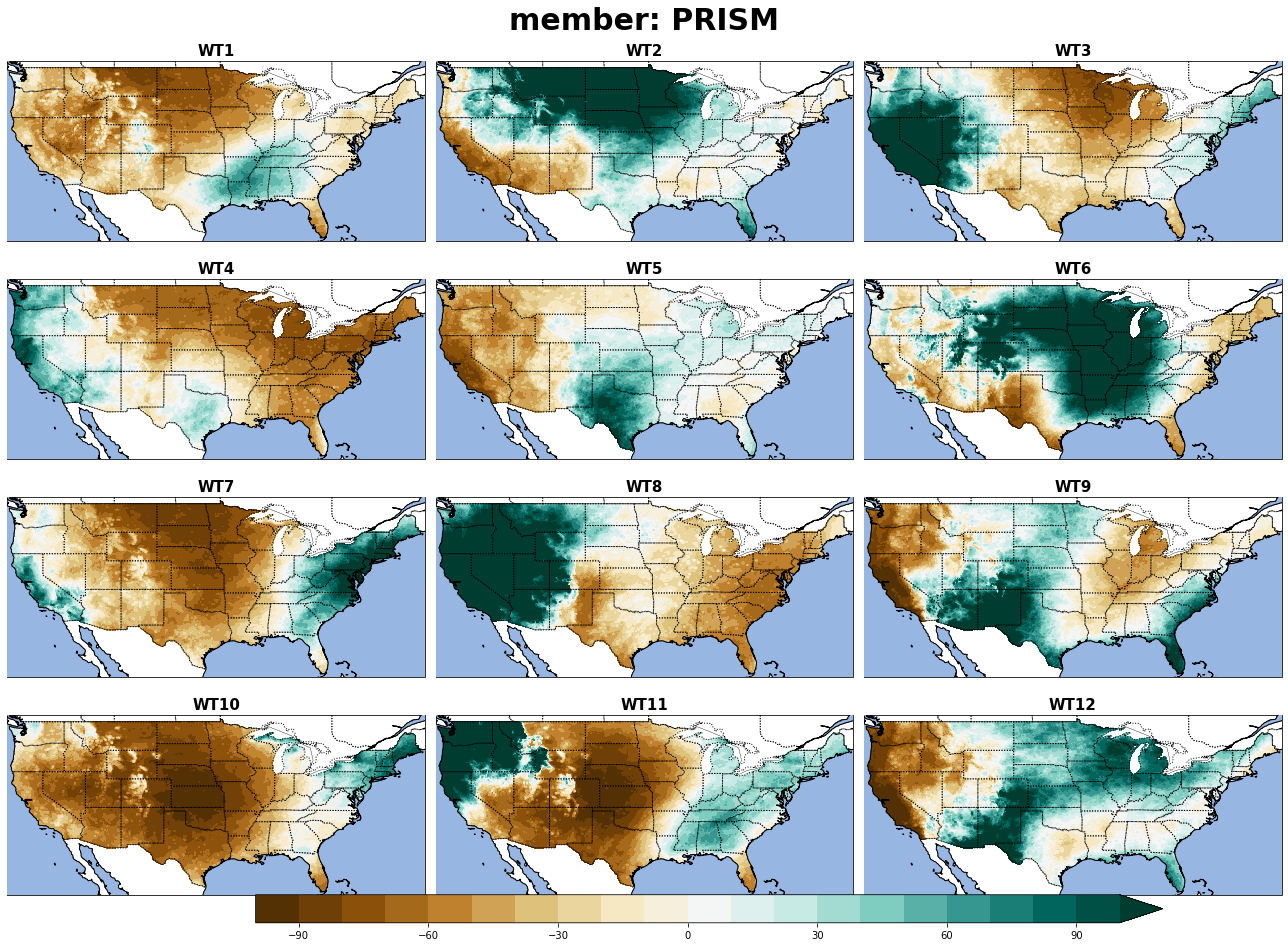

In [10]:
prec_avg = (prec_xr - prec_mean)/prec_mean*100
plot_prec_12(prec_avg, -100, 100, 21, 'BrBG', 'horizontal', 'PRISM') 